<a href="https://colab.research.google.com/github/deepjyotisaha85/eva4/blob/master/session12/S12_TinyImageNet_(LR_RangeTest).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/S12'
sys.path.append(workingdir)

In [0]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from utils import datapreparation
from utils import display
from model import dnn
from model import resnet
from utils import training
from utils import evaluate
from utils import lrfinder
from utils import lrrangetest
from utils import gradcam 
from utils import gradvisualize 

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
classes, trainloader, testloader = datapreparation.load('tinyimagenet', 70, batch_size=512, split=True, albumentations=True)


CUDA Available? True


shape: torch.Size([512, 3, 64, 64])


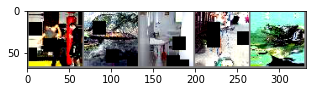

n04023962 n01784675 n03970156 n03649909 n01641577


In [0]:
display.show_random_images(trainloader, classes, 5)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.ResNet18(num_classes=200)
model = net.to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


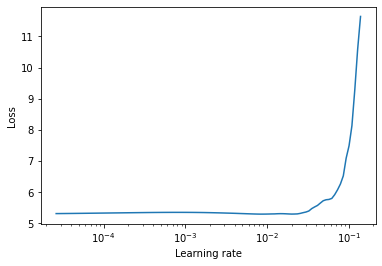

In [0]:
#LR Finder Test
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

lr_finder =lrfinder.LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(trainloader,testloader, start_lr=1e-5, end_lr=2, num_iter=len(trainloader), step_mode="exp")
lr_finder.plot()
lr_finder.reset()

In [0]:
best_loss = lr_finder.best_loss
best_lr = lr_finder.history["lr"][lr_finder.history["loss"].index(best_loss)]
print("Best Loss: %s\nBest Learning Rate: %s" % (best_loss, best_lr))

Best Loss: 5.28552729639345
Best Learning Rate: 0.008199949724922407


In [0]:
#LR Finder Best Learning Rate:
best_lr = 0.008199949724922407

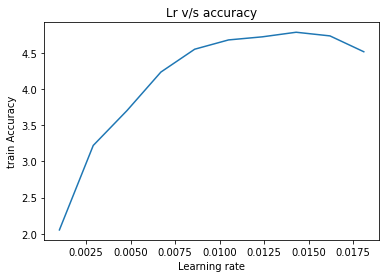

In [0]:
#LR Range Test
max_lr = 0.02
min_lr = 0.001
lr_rangetest_epoch = 10
lrrangetest.LR_test(max_lr, min_lr, device, lr_rangetest_epoch, model, criterion, trainloader, momemtum = 0.9, weight_decay=0.05, plot= True)

In [0]:
#best_lr = 0.008199949724922407
#optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=0.9)
#scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.1, patience=3,verbose=True, min_lr=1e-5)

In [0]:
#Use the values obtained from LR Range Test, the max accuracy is achieved at 0.014, hence this is max_lr, and min_lr is .10 times max_lr
initial_lr = 0.001
max_lr = 0.014
min_lr = max_lr * 0.1

EPOCHS = 50
steps_per_epoch = len(trainloader)
num_steps = steps_per_epoch * EPOCHS
peak_lr_epoch = 20 
pct_start = float (peak_lr_epoch/EPOCHS)
div_factor = float (max_lr/initial_lr)
final_div_factor = float (initial_lr/min_lr)

print("maxlr: ", max_lr)
print("min_lr: ", min_lr)
print("initial_lr: ", initial_lr)
print("epochs: ", EPOCHS)
print("steps_per_epoch: ", steps_per_epoch)
print("pct_start: ", pct_start)
print("div_factor: ", div_factor)
print("final_div_factor: ", final_div_factor)


optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch=steps_per_epoch, 
                                                pct_start=pct_start, 
                                                anneal_strategy='cos', 
                                                cycle_momentum=True, 
                                                base_momentum=0.85, 
                                                max_momentum=0.95, 
                                                div_factor=div_factor, 
                                                final_div_factor=final_div_factor, 
                                                last_epoch=-1)

maxlr:  0.014
min_lr:  0.0014000000000000002
initial_lr:  0.001
epochs:  50
steps_per_epoch:  151
pct_start:  0.4
div_factor:  14.0
final_div_factor:  0.7142857142857142


In [0]:
misclassified_imgs = []
correct_imgs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
    training.train_model(epoch, model, device, trainloader, criterion, optimizer, scheduler)
    misclassified_imgs, correct_imgs = training.test_model(model, device, testloader, criterion, epoch==EPOCHS-1)

  0%|          | 0/151 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.0009999999999999992


Loss=4.974625110626221 Batch_id=150 Accuracy=2.50: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0096, Accuracy: 1451/33000 (4.40%)

EPOCH: 2 LR: 0.0010800787005333448


Loss=4.618506908416748 Batch_id=150 Accuracy=6.23: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 2560/33000 (7.76%)

EPOCH: 3 LR: 0.0013183416949705765


Loss=4.183382034301758 Batch_id=150 Accuracy=9.54: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0084, Accuracy: 3410/33000 (10.33%)

EPOCH: 4 LR: 0.0017089182783948612


Loss=3.8497862815856934 Batch_id=150 Accuracy=12.94: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 3958/33000 (11.99%)

EPOCH: 5 LR: 0.002242184799957159


Loss=3.8318045139312744 Batch_id=150 Accuracy=16.22: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 5490/33000 (16.64%)

EPOCH: 6 LR: 0.0029050017857852727


Loss=3.530867576599121 Batch_id=150 Accuracy=18.88: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0071, Accuracy: 6225/33000 (18.86%)

EPOCH: 7 LR: 0.0036810376903664184


Loss=3.38734769821167 Batch_id=150 Accuracy=21.71: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6561/33000 (19.88%)

EPOCH: 8 LR: 0.004551171299298731


Loss=3.2613725662231445 Batch_id=150 Accuracy=24.61: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0070, Accuracy: 6843/33000 (20.74%)

EPOCH: 9 LR: 0.00549396286836876


Loss=3.1053476333618164 Batch_id=150 Accuracy=27.24: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8444/33000 (25.59%)

EPOCH: 10 LR: 0.006486182390276533


Loss=3.1096715927124023 Batch_id=150 Accuracy=29.85: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0064, Accuracy: 8313/33000 (25.19%)

EPOCH: 11 LR: 0.007503381972727224


Loss=2.65745210647583 Batch_id=150 Accuracy=32.34: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 8191/33000 (24.82%)

EPOCH: 12 LR: 0.008520498224722148


Loss=2.8403005599975586 Batch_id=150 Accuracy=34.42: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0056, Accuracy: 10934/33000 (33.13%)

EPOCH: 13 LR: 0.00951246980849174


Loss=2.874363660812378 Batch_id=150 Accuracy=36.85: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0057, Accuracy: 10537/33000 (31.93%)

EPOCH: 14 LR: 0.010454854940837761


Loss=2.5107452869415283 Batch_id=150 Accuracy=38.59: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0061, Accuracy: 9870/33000 (29.91%)

EPOCH: 15 LR: 0.011324433628898605


Loss=2.3763608932495117 Batch_id=150 Accuracy=40.36: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0062, Accuracy: 9635/33000 (29.20%)

EPOCH: 16 LR: 0.012099779801489224


Loss=2.4199764728546143 Batch_id=150 Accuracy=42.19: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 11707/33000 (35.48%)

EPOCH: 17 LR: 0.012761789238928218


Loss=2.252861261367798 Batch_id=150 Accuracy=43.84: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0054, Accuracy: 11763/33000 (35.65%)

EPOCH: 18 LR: 0.013294150293372223


Loss=2.545367479324341 Batch_id=150 Accuracy=45.41: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 12412/33000 (37.61%)

EPOCH: 19 LR: 0.0136837458012968


Loss=2.159289598464966 Batch_id=150 Accuracy=47.07: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0053, Accuracy: 12341/33000 (37.40%)

EPOCH: 20 LR: 0.013920976285160952


Loss=2.1108956336975098 Batch_id=150 Accuracy=48.87: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 12629/33000 (38.27%)

EPOCH: 21 LR: 0.013999998484995658


Loss=2.0945229530334473 Batch_id=150 Accuracy=49.90: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0050, Accuracy: 13305/33000 (40.32%)

EPOCH: 22 LR: 0.013965029738595572


Loss=2.090364694595337 Batch_id=150 Accuracy=51.63: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0049, Accuracy: 13630/33000 (41.30%)

EPOCH: 23 LR: 0.013861420015337675


Loss=1.8047599792480469 Batch_id=150 Accuracy=52.89: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 13791/33000 (41.79%)

EPOCH: 24 LR: 0.013690304485031706


Loss=1.7497856616973877 Batch_id=150 Accuracy=53.95: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 13997/33000 (42.42%)

EPOCH: 25 LR: 0.01345355792523593


Loss=1.9111253023147583 Batch_id=150 Accuracy=55.47: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0048, Accuracy: 14072/33000 (42.64%)

EPOCH: 26 LR: 0.013153774180801868


Loss=1.8347686529159546 Batch_id=150 Accuracy=56.73: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 14952/33000 (45.31%)

EPOCH: 27 LR: 0.01279423774516732


Loss=1.6136093139648438 Batch_id=150 Accuracy=57.92: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 15320/33000 (46.42%)

EPOCH: 28 LR: 0.01237888777475894


Loss=1.7594548463821411 Batch_id=150 Accuracy=59.35: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0047, Accuracy: 14507/33000 (43.96%)

EPOCH: 29 LR: 0.011912274930770085


Loss=1.5131378173828125 Batch_id=150 Accuracy=60.25: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0046, Accuracy: 14785/33000 (44.80%)

EPOCH: 30 LR: 0.011399511521164514


Loss=1.6265820264816284 Batch_id=150 Accuracy=61.71: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 15455/33000 (46.83%)

EPOCH: 31 LR: 0.010846215489160508


Loss=1.5426210165023804 Batch_id=150 Accuracy=62.98: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15288/33000 (46.33%)

EPOCH: 32 LR: 0.010258448861869345


Loss=1.4584379196166992 Batch_id=150 Accuracy=64.33: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15314/33000 (46.41%)

EPOCH: 33 LR: 0.009642651333457694


Loss=1.347304344177246 Batch_id=150 Accuracy=65.50: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15374/33000 (46.59%)

EPOCH: 34 LR: 0.009005569710510756


Loss=1.333857536315918 Batch_id=150 Accuracy=66.82: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15923/33000 (48.25%)

EPOCH: 35 LR: 0.008354183992607435


Loss=1.3062052726745605 Batch_id=150 Accuracy=68.42: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 16287/33000 (49.35%)

EPOCH: 36 LR: 0.0076956308979843025


Loss=1.139613151550293 Batch_id=150 Accuracy=69.59: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 15650/33000 (47.42%)

EPOCH: 37 LR: 0.00703712567215715


Loss=1.1490697860717773 Batch_id=150 Accuracy=70.91: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 16600/33000 (50.30%)

EPOCH: 38 LR: 0.006385883036181216


Loss=1.1607234477996826 Batch_id=150 Accuracy=72.40: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 16305/33000 (49.41%)

EPOCH: 39 LR: 0.005749038140657534


Loss=1.0831294059753418 Batch_id=150 Accuracy=73.66: 100%|██████████| 151/151 [02:13<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 16610/33000 (50.33%)

EPOCH: 40 LR: 0.005133568391529822


Loss=0.8747947216033936 Batch_id=150 Accuracy=75.04: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 16816/33000 (50.96%)

EPOCH: 41 LR: 0.004546217004164854


Loss=0.8484885692596436 Batch_id=150 Accuracy=76.69: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 17214/33000 (52.16%)

EPOCH: 42 LR: 0.003993419123273773


Loss=0.8174206614494324 Batch_id=150 Accuracy=78.17: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 17265/33000 (52.32%)

EPOCH: 43 LR: 0.0034812313181200195


Loss=0.7598814964294434 Batch_id=150 Accuracy=79.87: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17263/33000 (52.31%)

EPOCH: 44 LR: 0.0030152652254790482


Loss=0.8163808584213257 Batch_id=150 Accuracy=81.39: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17436/33000 (52.84%)

EPOCH: 45 LR: 0.002600626067371504


Loss=0.7341423034667969 Batch_id=150 Accuracy=82.96: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 17347/33000 (52.57%)

EPOCH: 46 LR: 0.002241856717182437


Loss=0.5608832240104675 Batch_id=150 Accuracy=84.29: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17686/33000 (53.59%)

EPOCH: 47 LR: 0.001942887926989831


Loss=0.5659636855125427 Batch_id=150 Accuracy=85.72: 100%|██████████| 151/151 [02:12<00:00,  1.14it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 17767/33000 (53.84%)

EPOCH: 48 LR: 0.0017069952614222773


Loss=0.5728031396865845 Batch_id=150 Accuracy=86.64: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17755/33000 (53.80%)

EPOCH: 49 LR: 0.001536763209887449


Loss=0.5815277099609375 Batch_id=150 Accuracy=87.31: 100%|██████████| 151/151 [02:13<00:00,  1.13it/s]
  0%|          | 0/151 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 17959/33000 (54.42%)

EPOCH: 50 LR: 0.0014340568703653082


Loss=0.5315214395523071 Batch_id=150 Accuracy=88.02: 100%|██████████| 151/151 [02:13<00:00,  1.14it/s]



Test set: Average loss: 0.0040, Accuracy: 17818/33000 (53.99%)



In [0]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 53 %


Gradcam

In [0]:
target_layers = ["layer1","layer2","layer3","layer4"]
viz_cam = gradvisualize.VisualizeCam(model, classes, target_layers)
print (viz_cam)

In [0]:
#len(testloader.dataset)
#print(misclassified_imgs[0]["img"])

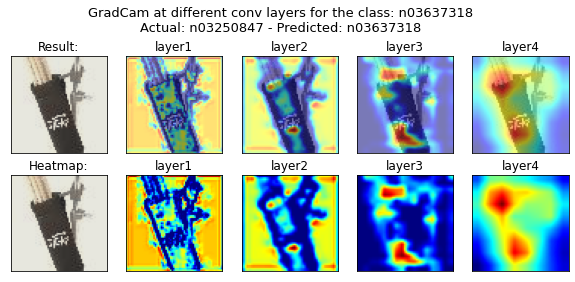

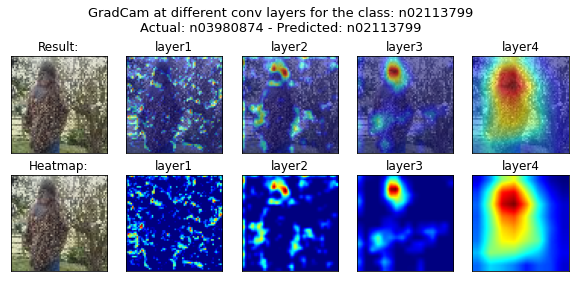

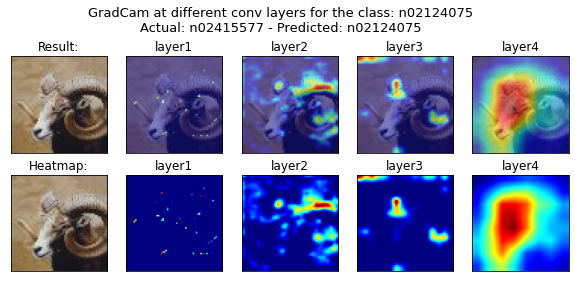

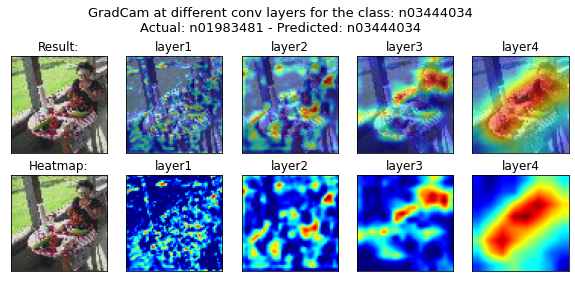

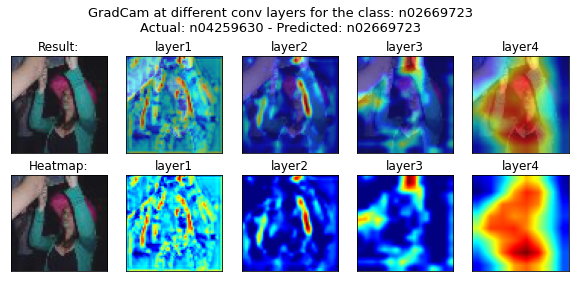

In [0]:
num_img = 5
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
  #incorrect_pred_imgs
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect")

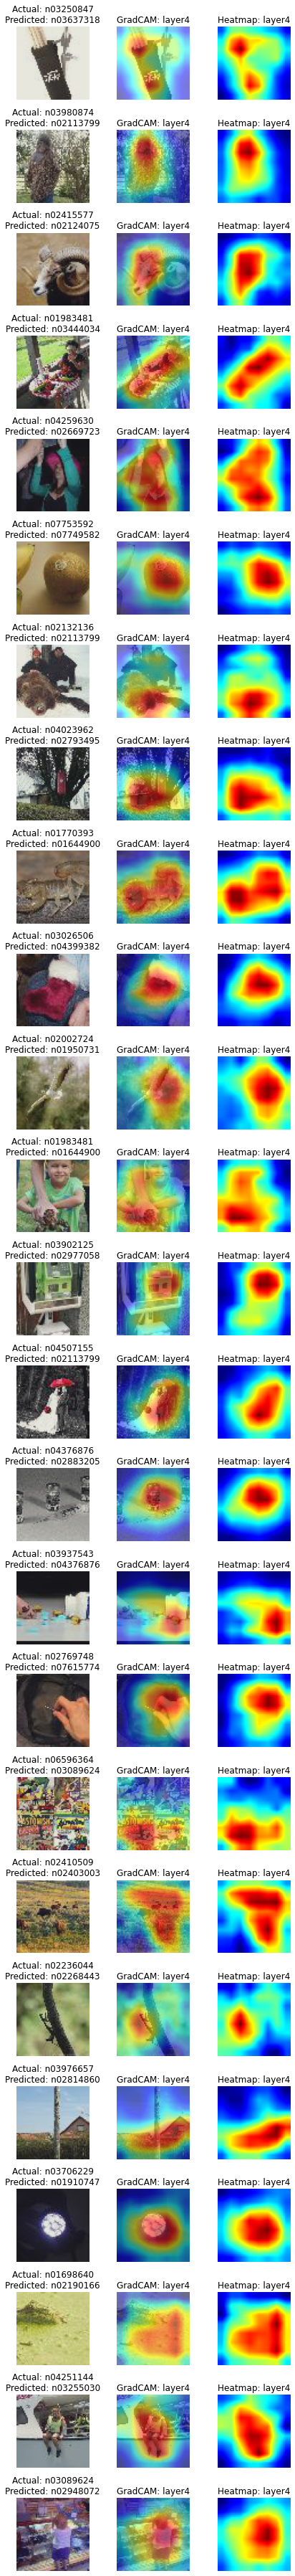

In [0]:
num_img = 25
incorrect_pred_imgs = []
truth_inds = []
for i in range(num_img):
  incorrect_pred_imgs.append(torch.as_tensor(misclassified_imgs[i]["img"]))
  truth_inds.append(misclassified_imgs[i]["target"])
viz_cam(torch.stack(incorrect_pred_imgs), truth_inds, target_layers, metric="incorrect", per_image=False)